# Circuit learning module: Lambeq's QuantumTrainer

This module performs the optimization with Lambeq's native optimizer. Because the circuits are constructed with Lambeq and DisCoPy, this optimizer is the natural choice. The code is based on the workflow presented in https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline.ipynb.

In [44]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
import numpy as np
import pickle
import math

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

# Uncomment if you do not want to access GPU
#os.environ["JAX_PLATFORMS"] = "cpu"

BATCH_SIZE = 32
EPOCHS = 1000
SEED = 0

## Select workload

In [45]:
# Select workload
workload = "small"
#workload = "medium"
#workload = "large"

# Select if we perform binary classification or multi-class classification
# Give number of qubits to create classes:
# 1 -> 2^1 = 2 classes i.e. binary classification
# 2 -> 2^2 = 4 classes
# ...
# 5 -> 2^5 = 32 classes, etc.

classification = 1

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//circuits//" + "binary_classification" + "//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

## Read circuits

We read the circuits from the pickled files.

In [46]:
def read_diagrams(circuit_paths):
    circuits = {}
    for serialized_diagram in circuit_paths:
        base_name = Path(serialized_diagram).stem
        f = open(serialized_diagram, "rb")
        diagram = pickle.load(f)
        circuits[base_name] = diagram
    return circuits


training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training, validation and test data

In [47]:
training_data, test_data, validation_data = None, None, None

data_path = this_folder + "//data//" + workload + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
    
def create_labeled_classes(data, classification):
    labeled_data = {}
    sorted_data = sorted(data, key=lambda d: d['time'])
    chunk_size = math.ceil(len(sorted_data)/2**classification)
    for i, clas in enumerate(chunks(sorted_data, chunk_size)):
        label = [0]*(2**classification)
        label[i] = 1
        for elem in clas:
            labeled_data[elem["name"]] = label
    return labeled_data


training_data_labels = create_labeled_classes(training_data, classification)
test_data_labels = create_labeled_classes(test_data, classification)
validation_data_labels = create_labeled_classes(validation_data, classification)

## Prepare circuits for the Lambeq optimizer

In [48]:
#all_circuits = list(training_circuits.values()) + list(test_circuits.values())

training_circuits_l = []
test_circuits_l = []
validation_circuits_l = []

training_data_labels_l = []
test_data_labels_l = []
validation_data_labels_l = []

# Organize circuits and labels in correct order into two lists which will be input for training the model
for key in training_data_labels:
    training_circuits_l.append(training_circuits[key])
    training_data_labels_l.append(training_data_labels[key])

for key in test_data_labels:
    test_circuits_l.append(test_circuits[key])
    test_data_labels_l.append(test_data_labels[key])
    
for key in validation_data_labels:
    validation_circuits_l.append(validation_circuits[key])
    validation_data_labels_l.append(validation_data_labels[key])

all_circuits = training_circuits_l + test_circuits_l + validation_circuits_l

train_syms = set([sym for circuit in training_circuits.values() for sym in circuit.free_symbols])
test_syms = set([sym for circuit in test_circuits.values() for sym in circuit.free_symbols])
val_syms = set([sym for circuit in validation_circuits.values() for sym in circuit.free_symbols])

print("Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", test_syms.difference(train_syms))
print("Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()): ", val_syms.difference(train_syms))

print("Total number of circuits: ", len(all_circuits))
print("Total number of variables: ", len(train_syms))

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 3276
}

Test circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Validation circuits need to share training circuits' parameters. The parameters that are not covered (should be empty set, set()):  set()
Total number of circuits:  29
Total number of variables:  76


## Select the model

Select the used model between `TketModel` or `NumpyModel`. `NumpyModel` can use JAX which speeds up the training.

In [5]:
#model = TketModel.from_diagrams(training_circuits_l, backend_config=backend_config)
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
model.initialise_weights()

## Define loss function and evaluation metrics

In [6]:
def acc(y_hat, y):
    return (np.sum(np.round(y_hat) == y) / len(y)) / 2

def loss(y_hat, y):
    return -np.sum(y * np.log(y_hat)) / len(y)

eval_metrics = {"acc": acc}

## Initialize the trainer and the datasets

In [7]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.91, 'c': 0.12, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

In [8]:
train_dataset = Dataset(training_circuits_l, training_data_labels_l)
val_dataset = Dataset(validation_circuits_l, validation_data_labels_l, shuffle=False)
test_dataset = Dataset(test_circuits_l, test_data_labels_l, shuffle=False)

Epoch 1:     train/loss: 0.8328   valid/loss: 0.7646   train/acc: 0.3684   valid/acc: 0.4000
Epoch 100:   train/loss: 0.7240   valid/loss: 0.7698   train/acc: 0.4737   valid/acc: 0.4000
Epoch 200:   train/loss: 0.6892   valid/loss: 0.6292   train/acc: 0.6316   valid/acc: 0.6000
Epoch 300:   train/loss: 0.6987   valid/loss: 0.6332   train/acc: 0.5789   valid/acc: 0.8000
Epoch 400:   train/loss: 0.5850   valid/loss: 0.1405   train/acc: 0.7368   valid/acc: 1.0000
Epoch 500:   train/loss: 0.6389   valid/loss: 0.5561   train/acc: 0.7368   valid/acc: 0.8000
Epoch 600:   train/loss: 0.3704   valid/loss: 0.2474   train/acc: 0.9474   valid/acc: 1.0000
Epoch 700:   train/loss: 0.4410   valid/loss: 0.2606   train/acc: 0.8947   valid/acc: 0.8000
Epoch 800:   train/loss: 0.4221   valid/loss: 0.3346   train/acc: 1.0000   valid/acc: 0.8000
Epoch 900:   train/loss: 0.3957   valid/loss: 0.2365   train/acc: 0.8947   valid/acc: 1.0000
Epoch 1000:  train/loss: 0.4693   valid/loss: 0.2454   train/acc: 0.94

## Train the model

In [ ]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=100)

## Visualize the training process and results

76
[0.10707188 0.892928  ]
[0.1053225 0.8946776]
[0.23021893 0.76978105]
[0.7899425 0.2100575]
[0.84888023 0.15111983]
[0, 1]
[0, 1]
[0, 1]
[1, 0]
[1, 0]
Test accuracy: 1.0


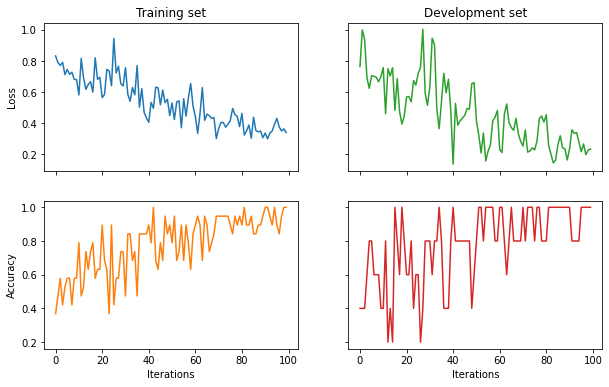

In [9]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

for e in model(test_circuits_l):
    print(e)
for e in test_data_labels_l:
    print(e)

# print test accuracy
test_acc = acc(model(test_circuits_l), test_data_labels_l)
print('Test accuracy:', test_acc.item())